<a href="https://colab.research.google.com/github/limweiliang/weed-classifier/blob/main/CS3244_ProjectCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Nov 24 21:44:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.76       Driver Version: 496.76       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P8    12W /  N/A |    959MiB /  6144MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math
import tensorflow_addons as tfa

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Define constants
RANDOM_STATE = 4242
NUM_CLASSES = 9

# ds = tfds.load('deep_weeds', batch_size = -1, as_supervised= True)
# images, labels = ds['train'] # Type: EagerTensor

# # Shuffle the dataset
# images = tf.random.shuffle(images, seed=RANDOM_STATE)
# labels = tf.random.shuffle(labels, seed=RANDOM_STATE)

# print(images.shape, labels.shape)

# # Split dataset into train-val-test
# num_images = images.shape[0]
# last_train_image = math.floor(num_images * 0.6)
# last_val_image = math.floor(num_images * 0.8)

# X_train = images[:last_train_image]
# y_train = labels[:last_train_image]
# X_val = images[last_train_image:last_val_image]
# y_val = labels[last_train_image:last_val_image]
# X_test = images[last_val_image:]
# y_test = labels[last_val_image:]

# print(X_train.shape, X_val.shape, X_test.shape)

In [5]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

train_ds, validation_ds, test_ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, split=["train[:70%]", "train[70%:90%]", "train[90%:100%]"], batch_size = BATCH_SIZE)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

#Pre-Processing
def one_hot(img, label):
    return (img, tf.one_hot(label,9))

def add_grey_grad(img ,label):
    org_img = img
    img = tf.cast(img, float)
    #img = tf.expand_dims(img, axis = 0)
    gray = tf.image.rgb_to_grayscale(img)
    dy , dx = tf.image.image_gradients(gray)
    dmag = tf.math.sqrt(tf.add(tf.math.square(dy),tf.math.square(dx)))

    #Normalize to 0 - 255
    im_max = tf.math.reduce_max(dmag)
    im_min = tf.math.reduce_min(dmag)
    out = (tf.math.subtract(dmag, im_min) / (im_max - im_min)) * 255
    out = tf.expand_dims(tf.cast(out, tf.uint8), axis = 0)
    out = tfa.image.gaussian_filter2d(out[0])
    
    gray = tf.expand_dims(tf.cast(gray, tf.uint8), axis = 0)
    org_img = tf.concat([org_img,gray[0],out],-1)
    return (org_img, label)

train_ds = train_ds.map(one_hot)
validation_ds = validation_ds.map(one_hot)
test_ds = test_ds.map(one_hot)

train_ds = train_ds.map(add_grey_grad)
validation_ds = validation_ds.map(add_grey_grad)
test_ds = test_ds.map(add_grey_grad)


train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
validation_ds = validation_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
test_ds = test_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()

Number of training samples: 96
Number of validation samples: 28
Number of test samples: 14


In [6]:
# Clean up memory usage
# del ds
# del images
# del labels

In [7]:
from tensorflow.keras import datasets, layers, models, regularizers, Input
import datetime

In [8]:
inputs = Input(shape = (256,256,5), name = "Original_Image")
flip = layers.RandomFlip("horizontal_and_vertical")(inputs)
rotate = layers.RandomRotation((-0.5,0.5), fill_mode = "nearest")(flip)
rescale = layers.Rescaling(1/255)(rotate)

x = layers.Conv2D(32, (3,3), padding = "same", strides = 2)(rescale)
x = layers.Conv2D(64, (3,3), padding = "same", strides = 2)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
block_1_output = layers.MaxPool2D(3,3)(x)

x = layers.Conv2D(128, (3,3), padding = "same")(block_1_output)
x = layers.Conv2D(128, (3,3), padding = "same")(x)
x = layers.BatchNormalization()(x)
block_2_output = layers.ReLU()(x)

x = layers.Conv2D(128, (3,3), padding = "same")(block_2_output)
x = layers.Conv2D(128, (3,3), padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.add([block_2_output,x])
block_3_output = layers.ReLU()(x)

x = layers.Conv2D(128, (3,3), padding = "same", strides = 2)(block_3_output)
x = layers.Conv2D(128, (3,3), padding = "same", strides = 2)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
block_4_output = layers.MaxPool2D()(x)

x = layers.Flatten()(block_4_output)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs, name="4_block_Resnet")
model.summary()

Model: "4_block_Resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Original_Image (InputLayer)     [(None, 256, 256, 5) 0                                            
__________________________________________________________________________________________________
random_flip (RandomFlip)        (None, 256, 256, 5)  0           Original_Image[0][0]             
__________________________________________________________________________________________________
random_rotation (RandomRotation (None, 256, 256, 5)  0           random_flip[0][0]                
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 5)  0           random_rotation[0][0]            
_____________________________________________________________________________________

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.005)


model.compile(optimizer=optimizer,
              loss= 'categorical_crossentropy',
              metrics=["Precision", "Recall",'accuracy','TruePositives','TrueNegatives','FalseNegatives','FalsePositives'])

In [12]:
model.summary()

Model: "4_block_Resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Original_Image (InputLayer)     [(None, 256, 256, 5) 0                                            
__________________________________________________________________________________________________
random_flip (RandomFlip)        (None, 256, 256, 5)  0           Original_Image[0][0]             
__________________________________________________________________________________________________
random_rotation (RandomRotation (None, 256, 256, 5)  0           random_flip[0][0]                
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 5)  0           random_rotation[0][0]            
_____________________________________________________________________________________

In [13]:
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True , verbose = 1)

#Constant learning rate for first N epochs then it decreases exponentially
# def scheduler(epoch, lr):
#   if epoch < 65:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1/5)

# lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=5, cooldown=10, verbose = 1)

checkpoint_filepath = "./CNN_Models/4_block_Resnet/4_blockResnetV1.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1)

In [14]:
hist = model.fit(train_ds, epochs=200,
                     validation_data= validation_ds, callbacks=[EarlyStop, reduce_lr, model_checkpoint_callback],batch_size = BATCH_SIZE)

Epoch 1/200
96/96 [==============================] - 48s 263ms/step - loss: 3.1456 - precision: 0.4979 - recall: 0.3422 - accuracy: 0.4606 - true_positives: 4194.0000 - true_negatives: 93818.0000 - false_negatives: 8062.0000 - false_positives: 4230.0000 - val_loss: 3.3125 - val_precision: 0.5141 - val_recall: 0.5089 - val_accuracy: 0.5103 - val_true_positives: 1782.0000 - val_true_negatives: 26332.0000 - val_false_negatives: 1720.0000 - val_false_positives: 1684.0000

Epoch 00001: val_loss improved from inf to 3.31252, saving model to ./CNN_Models/4_block_Resnet\4_blockResnetV1.h5
Epoch 2/200
96/96 [==============================] - 19s 194ms/step - loss: 1.4878 - precision: 0.6677 - recall: 0.3756 - accuracy: 0.5221 - true_positives: 4603.0000 - true_negatives: 95757.0000 - false_negatives: 7653.0000 - false_positives: 2291.0000 - val_loss: 1.7720 - val_precision: 0.6976 - val_recall: 0.2450 - val_accuracy: 0.4983 - val_true_positives: 858.0000 - val_true_negatives: 27644.0000 - val_f

96/96 [==============================] - 19s 203ms/step - loss: 0.7869 - precision: 0.8154 - recall: 0.6323 - accuracy: 0.7247 - true_positives: 7749.0000 - true_negatives: 96294.0000 - false_negatives: 4507.0000 - false_positives: 1754.0000 - val_loss: 1.4626 - val_precision: 0.6563 - val_recall: 0.5665 - val_accuracy: 0.6159 - val_true_positives: 1984.0000 - val_true_negatives: 26977.0000 - val_false_negatives: 1518.0000 - val_false_positives: 1039.0000- accuracy: 0.7239 - true_positives: 6930.0000 - true_negatives: 86240.0000 - false_negatives: 4046.0000 - fals

Epoch 00015: val_loss did not improve from 1.02862
Epoch 16/200
96/96 [==============================] - 20s 205ms/step - loss: 0.7535 - precision: 0.8201 - recall: 0.6474 - accuracy: 0.7346 - true_positives: 7934.0000 - true_negatives: 96307.0000 - false_negatives: 4322.0000 - false_positives: 1741.0000 - val_loss: 1.7738 - val_precision: 0.6286 - val_recall: 0.5491 - val_accuracy: 0.5777 - val_true_positives: 1923.0000 - v

96/96 [==============================] - 20s 210ms/step - loss: 0.6088 - precision: 0.8521 - recall: 0.7340 - accuracy: 0.7919 - true_positives: 8996.0000 - true_negatives: 96487.0000 - false_negatives: 3260.0000 - false_positives: 1561.0000 - val_loss: 1.0412 - val_precision: 0.7150 - val_recall: 0.6248 - val_accuracy: 0.6730 - val_true_positives: 2188.0000 - val_true_negatives: 27144.0000 - val_false_negatives: 1314.0000 - val_false_positives: 872.0000

Epoch 00027: val_loss did not improve from 0.88882
Epoch 28/200
96/96 [==============================] - 20s 210ms/step - loss: 0.5985 - precision: 0.8512 - recall: 0.7384 - accuracy: 0.7918 - true_positives: 9050.0000 - true_negatives: 96466.0000 - false_negatives: 3206.0000 - false_positives: 1582.0000 - val_loss: 2.3401 - val_precision: 0.4891 - val_recall: 0.4343 - val_accuracy: 0.4669 - val_true_positives: 1521.0000 - val_true_negatives: 26427.0000 - val_false_negatives: 1981.0000 - val_false_positives: 1589.0000rue_positives: 49

96/96 [==============================] - 20s 208ms/step - loss: 0.4350 - precision: 0.8896 - recall: 0.8137 - accuracy: 0.8479 - true_positives: 9973.0000 - true_negatives: 96810.0000 - false_negatives: 2283.0000 - false_positives: 1238.0000 - val_loss: 1.9201 - val_precision: 0.5839 - val_recall: 0.5394 - val_accuracy: 0.5528 - val_true_positives: 1889.0000 - val_true_negatives: 26670.0000 - val_false_negatives: 1613.0000 - val_false_positives: 1346.00006081.0000 - true_negatives: 58669.0000 - false_negatives: 1343.0000 - false_po - ETA: 3s - loss: 0.4287 - precision: 0.8914 - recall: 0.8174 - accuracy: 0.8504 - true_positives: 7821.0000 - true_negatives: 75591.0000 - false_negative

Epoch 00040: val_loss did not improve from 0.88882
Epoch 41/200
96/96 [==============================] - 20s 209ms/step - loss: 0.4329 - precision: 0.8847 - recall: 0.8132 - accuracy: 0.8504 - true_positives: 9966.0000 - true_negatives: 96749.0000 - false_negatives: 2290.0000 - false_positives: 1299.0000 

96/96 [==============================] - 20s 209ms/step - loss: 0.3245 - precision: 0.9109 - recall: 0.8611 - accuracy: 0.8851 - true_positives: 10554.0000 - true_negatives: 97016.0000 - false_negatives: 1702.0000 - false_positives: 1032.0000 - val_loss: 1.0299 - val_precision: 0.7372 - val_recall: 0.6808 - val_accuracy: 0.7047 - val_true_positives: 2384.0000 - val_true_negatives: 27166.0000 - val_false_negatives: 1118.0000 - val_false_positives: 850.0000

Epoch 00051: val_loss did not improve from 0.60768
Epoch 52/200
96/96 [==============================] - 20s 209ms/step - loss: 0.3146 - precision: 0.9154 - recall: 0.8682 - accuracy: 0.8908 - true_positives: 10641.0000 - true_negatives: 97064.0000 - false_negatives: 1615.0000 - false_positives: 984.0000 - val_loss: 1.2157 - val_precision: 0.6999 - val_recall: 0.6499 - val_accuracy: 0.6733 - val_true_positives: 2276.0000 - val_true_negatives: 27040.0000 - val_false_negatives: 1226.0000 - val_false_positives: 976.0000 true_positives: 

96/96 [==============================] - 20s 212ms/step - loss: 0.2388 - precision: 0.9331 - recall: 0.9027 - accuracy: 0.9164 - true_positives: 11064.0000 - true_negatives: 97255.0000 - false_negatives: 1192.0000 - false_positives: 793.0000 - val_loss: 0.8082 - val_precision: 0.7984 - val_recall: 0.7587 - val_accuracy: 0.7778 - val_true_positives: 2657.0000 - val_true_negatives: 27345.0000 - val_false_negatives: 845.0000 - val_false_positives: 671.0000.9046 - accuracy: 0.9188 - true_positives: 9118.0000 - true_negatives: 80015.0000 - false_negatives: 962.0

Epoch 00064: val_loss did not improve from 0.60483
Epoch 65/200
96/96 [==============================] - 20s 210ms/step - loss: 0.2441 - precision: 0.9302 - recall: 0.9001 - accuracy: 0.9152 - true_positives: 11032.0000 - true_negatives: 97220.0000 - false_negatives: 1224.0000 - false_positives: 828.0000 - val_loss: 0.8989 - val_precision: 0.7809 - val_recall: 0.7379 - val_accuracy: 0.7610 - val_true_positives: 2584.0000 - val_true

96/96 [==============================] - 20s 210ms/step - loss: 0.1797 - precision: 0.9468 - recall: 0.9256 - accuracy: 0.9361 - true_positives: 11344.0000 - true_negatives: 97410.0000 - false_negatives: 912.0000 - false_positives: 638.0000 - val_loss: 0.6694 - val_precision: 0.8400 - val_recall: 0.8155 - val_accuracy: 0.8261 - val_true_positives: 2856.0000 - val_true_negatives: 27472.0000 - val_false_negatives: 646.0000 - val_false_positives: 544.0000.9372 - true_positives: 9338.0000 - true_negatives: 80126.0000 - false_negatives: 742.0000 - fals - ETA: 0s - loss: 0.1792 - precision: 0.9467 - recall: 0.9255 - accuracy: 0.9360 - true_positives: 11106.0000 - true_negatives: 95375.0000 - false_negatives: 894.0000 - false_positives: 625.0

Epoch 00079: val_loss did not improve from 0.60244
Epoch 80/200
96/96 [==============================] - 20s 210ms/step - loss: 0.1782 - precision: 0.9488 - recall: 0.9291 - accuracy: 0.9378 - true_positives: 11387.0000 - true_negatives: 97433.0000 - fa

96/96 [==============================] - 20s 211ms/step - loss: 0.1364 - precision: 0.9610 - recall: 0.9457 - accuracy: 0.9532 - true_positives: 11591.0000 - true_negatives: 97577.0000 - false_negatives: 665.0000 - false_positives: 471.0000 - val_loss: 0.6660 - val_precision: 0.8574 - val_recall: 0.8358 - val_accuracy: 0.8432 - val_true_positives: 2927.0000 - val_true_negatives: 27529.0000 - val_false_negatives: 575.0000 - val_false_positives: 487.0000call: 0.9467 - accuracy: 0.9549 - true_positives: 5938.0000 - 

Epoch 00092: val_loss did not improve from 0.57154
Epoch 93/200
96/96 [==============================] - 20s 212ms/step - loss: 0.1306 - precision: 0.9599 - recall: 0.9457 - accuracy: 0.9528 - true_positives: 11591.0000 - true_negatives: 97564.0000 - false_negatives: 665.0000 - false_positives: 484.0000 - val_loss: 0.6043 - val_precision: 0.8665 - val_recall: 0.8489 - val_accuracy: 0.8552 - val_true_positives: 2973.0000 - val_true_negatives: 27558.0000 - val_false_negatives: 

96/96 [==============================] - 22s 226ms/step - loss: 0.1093 - precision: 0.9678 - recall: 0.9552 - accuracy: 0.9609 - true_positives: 11707.0000 - true_negatives: 97658.0000 - false_negatives: 549.0000 - false_positives: 390.0000 - val_loss: 0.7262 - val_precision: 0.8496 - val_recall: 0.8355 - val_accuracy: 0.8412 - val_true_positives: 2926.0000 - val_true_negatives: 27498.0000 - val_false_negatives: 576.0000 - val_false_positives: 518.00006 - accuracy: 0.9652 - true_positives: 2705.0000 - true_negatives: 22450.0000 - false_nega - ETA: 9s - loss: 0.1051 - precision: 0.9692 - recall: 0.9561 - accuracy: 0.9624 - true_positives: 6364.0000 - true_ne

Epoch 00107: val_loss did not improve from 0.54285
Epoch 108/200
96/96 [==============================] - 22s 227ms/step - loss: 0.1065 - precision: 0.9669 - recall: 0.9555 - accuracy: 0.9609 - true_positives: 11711.0000 - true_negatives: 97647.0000 - false_negatives: 545.0000 - false_positives: 401.0000 - val_loss: 0.7947 - val_pr

96/96 [==============================] - 22s 227ms/step - loss: 0.0970 - precision: 0.9706 - recall: 0.9601 - accuracy: 0.9646 - true_positives: 11767.0000 - true_negatives: 97691.0000 - false_negatives: 489.0000 - false_positives: 357.0000 - val_loss: 0.7180 - val_precision: 0.8550 - val_recall: 0.8401 - val_accuracy: 0.8452 - val_true_positives: 2942.0000 - val_true_negatives: 27517.0000 - val_false_negatives: 560.0000 - val_false_positives: 499.0000

Epoch 00122: val_loss did not improve from 0.54285
Epoch 123/200
96/96 [==============================] - 21s 222ms/step - loss: 0.0936 - precision: 0.9723 - recall: 0.9636 - accuracy: 0.9671 - true_positives: 11810.0000 - true_negatives: 97712.0000 - false_negatives: 446.0000 - false_positives: 336.0000 - val_loss: 0.7151 - val_precision: 0.8538 - val_recall: 0.8421 - val_accuracy: 0.8455 - val_true_positives: 2949.0000 - val_true_negatives: 27511.0000 - val_false_negatives: 553.0000 - val_false_positives: 505.0000

Epoch 00123: val_lo

96/96 [==============================] - 21s 222ms/step - loss: 0.0835 - precision: 0.9743 - recall: 0.9666 - accuracy: 0.9706 - true_positives: 11847.0000 - true_negatives: 97736.0000 - false_negatives: 409.0000 - false_positives: 312.0000 - val_loss: 0.6987 - val_precision: 0.8600 - val_recall: 0.8475 - val_accuracy: 0.8527 - val_true_positives: 2968.0000 - val_true_negatives: 27533.0000 - val_false_negatives: 534.0000 - val_false_positives: 483.0000

Epoch 00136: val_loss did not improve from 0.54285
Epoch 137/200
96/96 [==============================] - 21s 221ms/step - loss: 0.0836 - precision: 0.9756 - recall: 0.9680 - accuracy: 0.9717 - true_positives: 11864.0000 - true_negatives: 97751.0000 - false_negatives: 392.0000 - false_positives: 297.0000 - val_loss: 0.6012 - val_precision: 0.8732 - val_recall: 0.8609 - val_accuracy: 0.8661 - val_true_positives: 3015.0000 - val_true_negatives: 27578.0000 - val_false_negatives: 487.0000 - val_false_positives: 438.0000

Epoch 00137: val_lo

96/96 [==============================] - 21s 221ms/step - loss: 0.0810 - precision: 0.9727 - recall: 0.9654 - accuracy: 0.9688 - true_positives: 11832.0000 - true_negatives: 97716.0000 - false_negatives: 424.0000 - false_positives: 332.0000 - val_loss: 0.7021 - val_precision: 0.8621 - val_recall: 0.8532 - val_accuracy: 0.8572 - val_true_positives: 2988.0000 - val_true_negatives: 27538.0000 - val_false_negatives: 514.0000 - val_false_positives: 478.0000

Epoch 00150: val_loss did not improve from 0.54285
Epoch 151/200
96/96 [==============================] - 21s 220ms/step - loss: 0.0797 - precision: 0.9758 - recall: 0.9693 - accuracy: 0.9719 - true_positives: 11880.0000 - true_negatives: 97753.0000 - false_negatives: 376.0000 - false_positives: 295.0000 - val_loss: 0.6599 - val_precision: 0.8677 - val_recall: 0.8558 - val_accuracy: 0.8601 - val_true_positives: 2997.0000 - val_true_negatives: 27559.0000 - val_false_negatives: 505.0000 - val_false_positives: 457.0000ves: 9899.0000 - true

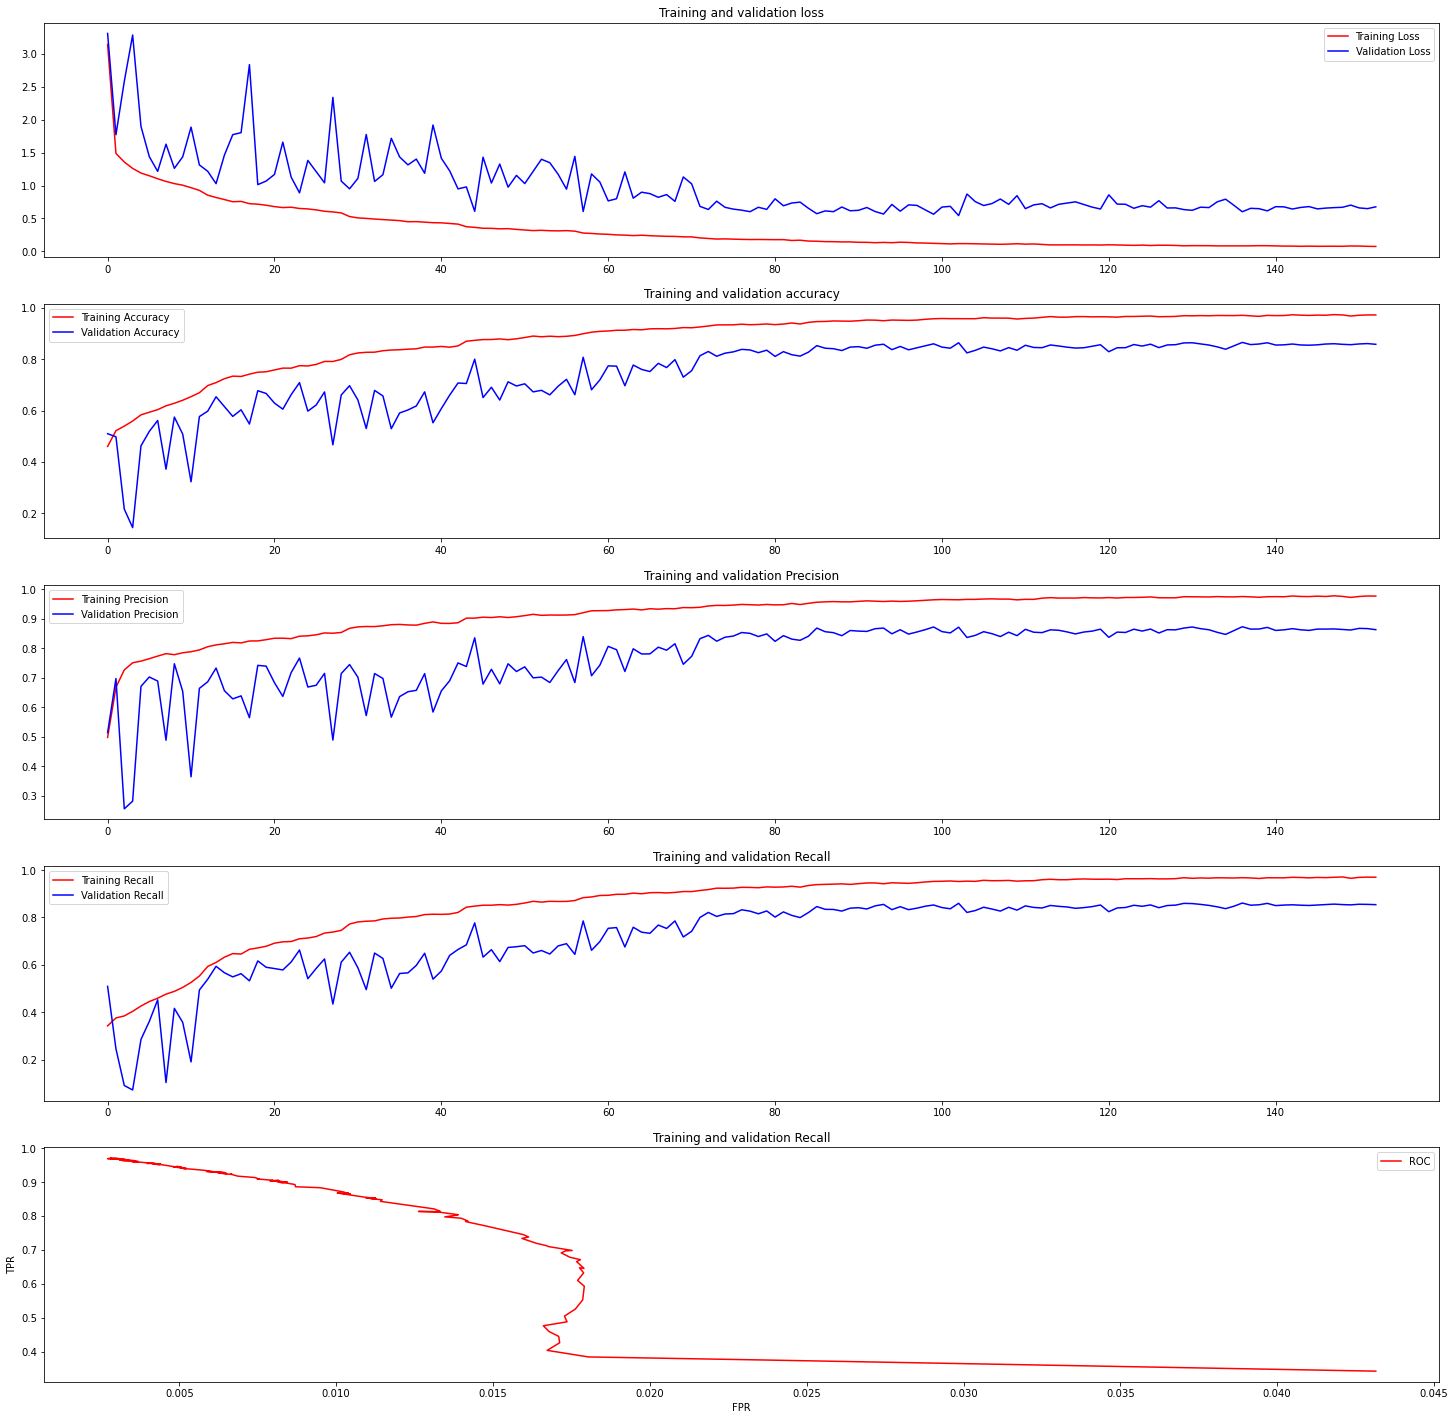

In [38]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
precision = hist.history['precision']
val_precision = hist.history['val_precision']
recall = hist.history['recall']
val_recall = hist.history['val_recall']

TP = np.array(hist.history['true_positives'])
val_TP = np.array(hist.history['val_true_positives'])

TN = np.array(hist.history['true_negatives'])
val_TN = np.array(hist.history['val_true_negatives'])

FN = np.array(hist.history['false_negatives'])
val_FN = np.array(hist.history['val_false_negatives'])

FP = np.array(hist.history['false_positives'])
val_FP = np.array(hist.history['val_false_positives'])

# Plot the graph manually
epochs = range(len(loss))

plt.figure(figsize=(25, 25))
plt.subplot(5, 1, 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and validation Precision')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(epochs, recall, 'r', label = "Training Recall")
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

TPR = TP / (TP + FN)
val_TPR = val_TP / (val_TP + val_FN)

FPR = FP / (FP + TN)
val_FPR = val_FP / (val_FP + val_TN)

plt.subplot(5, 1, 5)
plt.plot(FPR, TPR, 'r', label = "ROC")
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.plot(val_FPR, val_TPR, 'b', label='Validation ROC')
plt.title('Training and validation Recall')
plt.legend()

plt.show()

In [35]:
FPR

array([0.04314213, 0.02336611, 0.01804218, 0.0167265 , 0.01712427,
       0.01709367, 0.0167877 , 0.01660411, 0.01735884, 0.01727725,
       0.01762402, 0.0178586 , 0.0179096 , 0.01769541, 0.0178892 ,
       0.01775661, 0.0178994 , 0.01766482, 0.01778721, 0.01745064,
       0.01717526, 0.01730785, 0.01752203, 0.0167673 , 0.0166857 ,
       0.01638993, 0.01592077, 0.01613495, 0.01596157, 0.01470708,
       0.01424812, 0.01412573, 0.01419713, 0.01398295, 0.01356478,
       0.01346279, 0.01375857, 0.01389116, 0.01323841, 0.01262647,
       0.01324861, 0.01330981, 0.01311602, 0.01141278, 0.01146377,
       0.01109661, 0.01125979, 0.01094362, 0.01125979, 0.01094362,
       0.01052546, 0.0100359 , 0.01045406, 0.01035207, 0.01038267,
       0.01035207, 0.01021948, 0.00949535, 0.00869982, 0.00868962,
       0.00865902, 0.00839385, 0.00827146, 0.00808788, 0.00844484,
       0.00795529, 0.00816947, 0.00789409, 0.00797569, 0.00748613,
       0.00754732, 0.00740454, 0.00686398, 0.00663961, 0.00668

In [39]:
model.evaluate(validation_ds)

28/28 [==============================] - 2s 59ms/step - loss: 0.5429 - precision: 0.8717 - recall: 0.8598 - accuracy: 0.8646 - true_positives: 3011.0000 - true_negatives: 27573.0000 - false_negatives: 491.0000 - false_positives: 443.0000


[0.5428515672683716,
 0.8717429041862488,
 0.8597943782806396,
 0.8646487593650818,
 3011.0,
 27573.0,
 491.0,
 443.0]

In [163]:
model.save('./CNN_Models/4_block_Resnet/4_blockResnetV1.h5')

In [5]:
model = models.load_model('CNN_Models/4_block_Resnet/4_blockResnetV1.h5')

In [6]:
model.summary()

Model: "2_block_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Original_Image (InputLayer)  [(None, 256, 256, 5)]     0         
_________________________________________________________________
random_flip_29 (RandomFlip)  (None, 256, 256, 5)       0         
_________________________________________________________________
random_rotation_29 (RandomRo (None, 256, 256, 5)       0         
_________________________________________________________________
rescaling_29 (Rescaling)     (None, 256, 256, 5)       0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 128, 128, 64)      2944      
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_56 (Batc (None, 64, 64, 64)        

In [7]:
model.compile()

In [15]:
test = tfds.as_numpy(test_ds)
y_pred = []
y_label = []

for i in test:
  flat_img = i[0]
  flat_label = i[1]
  pred = model.predict(flat_img)
  pred = np.argmax(pred, axis=1)
  y_pred.extend(pred)
  y_label.extend(np.argmax(flat_label, axis = 1))

y_pred = np.array(y_pred)
y_label = np.array(y_label)

In [16]:
len(y_pred)

1751

In [17]:
from sklearn.metrics import classification_report

print(y_pred)
print(classification_report(y_label, y_pred))

[8 8 8 ... 8 2 8]
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       103
           1       0.91      0.81      0.86        90
           2       0.94      0.85      0.90       116
           3       0.81      0.91      0.86       105
           4       0.80      0.83      0.82       108
           5       0.93      0.85      0.89        98
           6       0.92      0.86      0.89       114
           7       0.85      0.88      0.87       129
           8       0.92      0.95      0.93       888

    accuracy                           0.89      1751
   macro avg       0.88      0.85      0.86      1751
weighted avg       0.89      0.89      0.89      1751

